# AnnoTree-diamond-jupyter

This notebook is part of the analysis of the TotalRNA mRNA genes from Trinity.

## How to run Jupyter notebooks in huginn
<details>
<summary>Click to expand!</summary>

If you use vs-code you can use the [remote ssh extension](https://marketplace.visualstudio.com/items?itemName=ms-vscode-remote.remote-ssh) to connect to huginn and either run jupyterlab in the remote server (so to say, just like you would do in your local computer with `jupyter-lab`) or run directly without opening jupyterlab directly. 

Otherwise, you can follow the instructions below: 

1. Turn on VPN
2. Open two terminals (let's called A and B)
3. With terminal A, connect to huginn with ssh as usual
```bash
ssh username@huginn.au.dk
```
4. Move to the directory where you want to work, activate the conda enviroment and run jupyter notebook or jupyter lab:
```bash
conda activate jupyter-diamond
jupyter notebook --no-browser --port=7777
```
5. With terminal B, connect to huginn and forward the port specified port to your local computer
```bash
ssh -Y -N -L localhost:7777:localhost:7777 username@huginn.au.dk
```
6. Open your browser and go to `localhost:7777` and you should see the jupyter notebook running in huginn. You can also press in the url of Terminal A. 

Troubleshooting:
- If you get an error like `bind: Address already in use` it means that you have another jupyter notebook running in the same port. You can either kill the process or change the port.
</details>

## How to create a new environment for this notebook (if needed)

We will use Diamond, a few python basic libraries and bash. Let's check if those dependencies are installed. If not, you can install them with mamba (as well with jupyterlab)

```bash
# To create a new environment with mamba
mamba create -c bioconda -c conda-forge diamond pandas matplotlib jupyterlab -n jupyter-diamond
# To activate the environment
conda activate jupyter-diamond
```
##### What's Diamond
DIAMOND is a sequence aligner for protein and translated DNA searches designed for high-performance analysis of big sequence data. 

##### Why AnnoTree?
The NCBI-nr database is not explicitly designed for microbiome analysis, and its increasing size makes it unwieldy and computationally expensive for this purpose. The AnnoTree protein database is only one-quarter the size of the entire NCBI-nr database and is explicitly designed for metagenomic analysis, so alignment-based pipelines should support it.
https://journals.asm.org/doi/10.1128/msystems.01408-21

##### Which input files?

1. Trinity fasta file
2. Abundance-filtered coun table

##### Which preprocessing?

We use the naïve LCA (lowest common ancestor) approach for taxonomic annotation (Huson et al., 2007) and the best hit approach for functional assignment (Huson, Mitra, Weber, Ruscheweyh, & Schuster, 2011).

Then, this notebook is **heavily** inspired by Megan. 

##### Which database files?

We are using three different files (all of them in /Databases/AnnoTree_mRNA/)
'annotree.dmnd' is a diamond database (a particular format obtained from a fasta file)
'megan-mapping-annotree-June-2021.db' is an SQLite file with mappings from the name of each protein to annotations. 
'ko00001.json' is a JSON file with the BRITE hierarchy annotation  for KEGG

## Analysis
First, check dependencies. Safe to ignore. If any error, you can create a new conda enviroment with:

```bash
mamba create -n diamond_jupyter jupyterlab diamond pandas python=3 ete3 ete_toolchain -c conda-forge -c etetoolkit  -c bioconda
```


In [1]:
%%bash
diamond --version
python -c "import pandas; print(pandas.__version__)"
python -c "import matplotlib; print(matplotlib.__version__)"
python -c "import ete3; print(ete3.__version__)"
bash --version | head -n 1

diamond version 2.1.8
1.1.5
3.3.4
3.1.2
GNU bash, version 4.4.20(1)-release (x86_64-pc-linux-gnu)


In [2]:
import os
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
from contextlib import closing
from enum import Enum

### Input files (edit this chunk)
Edit this chunk to match your input files

In [3]:
trinity_file = '../data/contigs.fasta'
count_table = '../data/mapped_reads_to_contigs.tsv'

In [4]:
## Sanity check: trinity and count table exit
assert os.path.exists(trinity_file), 'Trinity file does not exist'
assert os.path.exists(count_table), 'Count table does not exist'

### Output files (edit this chunk)
Edit this chunk to match your desired output files

In [5]:
outfile_matches = '../results/Annotree_matches.tsv'

### Database files
Don't edit this chunk

In [6]:
annotree_db = '/data_2/Databases/AnnoTree_mRNA/annotree'
mapping_db = '/data_2/Databases/AnnoTree_mRNA/megan-mapping-annotree-June-2021.db'
brite_json = '/data_2/Databases/AnnoTree_mRNA/ko00001.json'
assert os.path.exists(f"{annotree_db}.dmnd"), 'Annotree database does not exist'
assert os.path.exists(mapping_db), 'Mapping database does not exist'
assert os.path.exists(brite_json), 'Brite json file does not exist'

##### Run Diamond
When using Diamond, you should consider which sensitivity mode do you want to use. Default mode is designed for finding hits of >60% identity and it should take less than one hour to run. You might consider increase the sensitivity by editing the chunk below. 

In [7]:
%%bash -s "$annotree_db" "$trinity_file" "$outfile_matches"
if [ ! -f $3 ]; then
mkdir -p $(dirname $3)
diamond blastx -p 50 -d $1 -q $2 -o $3
fi
head $3


TRINITY_DN226500_c0_g1_i1	NZ_LT934425_1_2685__RS_GCF_900232105_1	100	70	0	0	2	211	540	609	3.90e-42	154
TRINITY_DN226500_c0_g1_i1	NZ_LT934425_1_3564__RS_GCF_900232105_1	100	70	0	0	2	211	540	609	3.90e-42	154
TRINITY_DN226500_c0_g1_i1	MHZD01000094_1_2__GB_GCA_001828645_1	82.6	69	12	0	5	211	542	610	7.84e-34	130
TRINITY_DN226500_c0_g1_i1	NZ_BAFN01000001_1_2593__RS_GCF_000949635_1	81.2	69	13	0	5	211	532	600	2.72e-33	129
TRINITY_DN226500_c0_g1_i1	NZ_BAFN01000001_1_626__RS_GCF_000949635_1	81.2	69	13	0	5	211	532	600	2.72e-33	129
TRINITY_DN226500_c0_g1_i1	NZ_MJUW02000123_1_3__RS_GCF_001753675_2	79.7	69	14	0	5	211	533	601	3.71e-33	128
TRINITY_DN226500_c0_g1_i1	LAQJ01000129_1_1__GB_GCA_000987375_1	81.2	69	13	0	5	211	542	610	6.80e-33	127
TRINITY_DN226500_c0_g1_i1	SULG01000157_1_3__GB_GCA_005524015_1	81.2	69	13	0	5	211	542	610	1.30e-32	127
TRINITY_DN226500_c0_g1_i1	AYTS01000080_1_2__GB_GCA_002009475_1	79.7	69	14	0	5	211	542	610	3.30e-32	125
TRINITY_DN226500_c0_g1_i1	NZ_BAFH01000001_1_83__RS_GCF_0002

##### Preprocessing Diamond matches
We read the file into a pandas table:

In [8]:
diamond = pd.read_csv(
    outfile_matches,delimiter='\t',comment='#', header=None,
    names= ['Query_id', 'Subject_id', '%_identity', 'alignment_length', 
             'mismatches','gap_openings','q_start', 'q_end',
             's_start',
              's_end', 'e-value', 'score'
            ]
)
diamond

,Query_id,Subject_id,%_identity,alignment_length,mismatches,gap_openings,q_start,q_end,s_start,s_end,e-value,score
0,TRINITY_DN226500_c0_g1_i1,NZ_LT934425_1_2685__RS_GCF_900232105_1,100.0,70,0,0,2,211,540,609,3.900000e-42,154.0
1,TRINITY_DN226500_c0_g1_i1,NZ_LT934425_1_3564__RS_GCF_900232105_1,100.0,70,0,0,2,211,540,609,3.900000e-42,154.0
2,TRINITY_DN226500_c0_g1_i1,MHZD01000094_1_2__GB_GCA_001828645_1,82.6,69,12,0,5,211,542,610,7.840000e-34,130.0
3,TRINITY_DN226500_c0_g1_i1,NZ_BAFN01000001_1_2593__RS_GCF_000949635_1,81.2,69,13,0,5,211,532,600,2.720000e-33,129.0
4,TRINITY_DN226500_c0_g1_i1,NZ_BAFN01000001_1_626__RS_GCF_000949635_1,81.2,69,13,0,5,211,532,600,2.720000e-33,129.0
...,...,...,...,...,...,...,...,...,...,...,...,...
202,TRINITY_DN78676876898_c0_g1_i1,NZ_JPOG01000001_1_606__RS_GCF_000733765_1,68.0,490,157,0,15032,16501,16,505,1.610000e-221,693.0
203,TRINITY_DN78676876898_c0_g1_i1,NZ_AKGD01000001_1_1387__RS_GCF_000271305_1,67.1,504,165,1,14993,16501,2,505,2.190000e-221,693.0
204,TRINITY_DN78676876898_c0_g1_i1,NZ_QICN01000017_1_15__RS_GCF_003201205_1,67.8,490,158,0,15032,16501,16,505,1.910000e-220,690.0
205,TRINITY_DN78676876898_c0_g1_i1,NZ_CP021361_1_1075__RS_GCF_002157145_1,99.7,332,1,0,23179,24174,1,332,4.510000e-220,681.0


We also add the count table into a Pandas data frame:

In [9]:
counts = pd.read_csv(
    count_table, sep = "\t", comment='#'
).set_index('ContigID')
counts

,SampleA,SampleB,SampleC,SampleD,SampleE
ContigID,,,,,
TRINITY_DN226500_c0_g1_i1,0,0,2,1,0
TRINITY_DN226510_c0_g1_i1,1,0,0,0,5
TRINITY_DN226477_c0_g1_i1,0,0,0,0,0
TRINITY_DN226449_c0_g1_i1,0,0,2,0,0
TRINITY_DN226457_c0_g1_i1,3,6,0,0,0
TRINITY_DN226454_c0_g1_i1,0,0,0,9,0
TRINITY_DN226455_c0_g1_i1,0,2,0,0,2
TRINITY_DN2264898_c0_g1_i1,0,2,1,1,2
TRINITY_DN78676876898_c0_g1_i1,0,2,1,1,20


# Preprocessing

The thresholds we are going to use should be adapted to the data. 

### Min-score
We are going to set a minimum threshol for the score to be **considered**. The read length is relevant for this choice. Please, be aware the next chunk of code *only* works for Trinity fasta files. If you are using another assembler, you should change the code accordingly.

In [10]:
%%bash -s "$trinity_file"
grep ">" $1 | awk '{print $2}' | sed 's/len=//g' > ../results/contig_lengths.txt

Mean: 236.6


<AxesSubplot:ylabel='Density'>

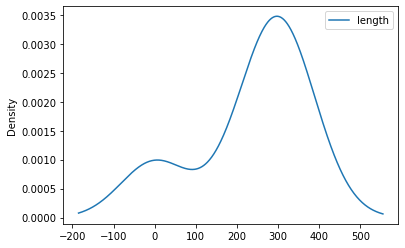

In [11]:
# read contig lengths and plot histogram
read_length = pd.read_csv(
    '../results/contig_lengths.txt', header=None, names=['length']
)
print(f"Mean: {read_length['length'].mean()}")
read_length.plot(kind='density')

For reads ∼100 bp, something like a min-score of 35 is reasonable. For longer reads, ∼800 bp, a min-score of 100 is reasonable.

In [12]:
min_score_threshold = 100
diamond_filtered = diamond[diamond.score > min_score_threshold]
diamond_filtered

,Query_id,Subject_id,%_identity,alignment_length,mismatches,gap_openings,q_start,q_end,s_start,s_end,e-value,score
0,TRINITY_DN226500_c0_g1_i1,NZ_LT934425_1_2685__RS_GCF_900232105_1,100.0,70,0,0,2,211,540,609,3.900000e-42,154.0
1,TRINITY_DN226500_c0_g1_i1,NZ_LT934425_1_3564__RS_GCF_900232105_1,100.0,70,0,0,2,211,540,609,3.900000e-42,154.0
2,TRINITY_DN226500_c0_g1_i1,MHZD01000094_1_2__GB_GCA_001828645_1,82.6,69,12,0,5,211,542,610,7.840000e-34,130.0
3,TRINITY_DN226500_c0_g1_i1,NZ_BAFN01000001_1_2593__RS_GCF_000949635_1,81.2,69,13,0,5,211,532,600,2.720000e-33,129.0
4,TRINITY_DN226500_c0_g1_i1,NZ_BAFN01000001_1_626__RS_GCF_000949635_1,81.2,69,13,0,5,211,532,600,2.720000e-33,129.0
...,...,...,...,...,...,...,...,...,...,...,...,...
202,TRINITY_DN78676876898_c0_g1_i1,NZ_JPOG01000001_1_606__RS_GCF_000733765_1,68.0,490,157,0,15032,16501,16,505,1.610000e-221,693.0
203,TRINITY_DN78676876898_c0_g1_i1,NZ_AKGD01000001_1_1387__RS_GCF_000271305_1,67.1,504,165,1,14993,16501,2,505,2.190000e-221,693.0
204,TRINITY_DN78676876898_c0_g1_i1,NZ_QICN01000017_1_15__RS_GCF_003201205_1,67.8,490,158,0,15032,16501,16,505,1.910000e-220,690.0
205,TRINITY_DN78676876898_c0_g1_i1,NZ_CP021361_1_1075__RS_GCF_002157145_1,99.7,332,1,0,23179,24174,1,332,4.510000e-220,681.0


##  Top-percent filter
We are going to keep all hits that are within the top 10% of the best hit (a useful range is 10%-20%). The lowest, the more over-prediction. The highest, the more 'vague' the annotation. Imagine a very well-conserved protein, it's likely that if you include all the hits you will end with a 'vague' annotation such as *Bacteria*. 

In [13]:
def top_percent_filter(group, threshold=0.95):
    max_score = group['score'].max()
    return group[group['score'] >= threshold * max_score]

diamond_filtered = diamond_filtered.groupby('Query_id').apply(top_percent_filter).reset_index(drop=True)
diamond_filtered

,Query_id,Subject_id,%_identity,alignment_length,mismatches,gap_openings,q_start,q_end,s_start,s_end,e-value,score
0,TRINITY_DN226455_c0_g1_i1,MKWE01000003_1_73__GB_GCA_001899585_1,86.0,93,13,0,20,298,191,283,1.830000e-44,157.0
1,TRINITY_DN226457_c0_g1_i1,NZZG01000135_1_4__GB_GCA_002698575_1,80.6,67,13,0,1,201,6,72,7.380000e-31,118.0
2,TRINITY_DN226457_c0_g1_i1,NZ_FQVU01000003_1_87__RS_GCF_900129455_1,78.6,70,15,0,1,210,6,75,1.040000e-30,117.0
3,TRINITY_DN226457_c0_g1_i1,NZ_CP041091_1_1971__RS_GCF_006494815_1,79.1,67,14,0,1,201,6,72,7.990000e-30,115.0
4,TRINITY_DN226457_c0_g1_i1,NZ_SPUJ01000010_1_43__RS_GCF_004522105_1,79.1,67,14,0,1,201,6,72,7.990000e-30,115.0
5,TRINITY_DN226457_c0_g1_i1,NZ_KE383929_1_629__RS_GCF_000422825_1,77.6,67,15,0,1,201,6,72,1.120000e-29,115.0
6,TRINITY_DN226457_c0_g1_i1,SCQZ01000232_1_9__GB_GCA_004299665_1,77.1,70,16,0,1,210,6,75,1.120000e-29,115.0
7,TRINITY_DN226457_c0_g1_i1,PBYI01000065_1_5__GB_GCA_002729525_1,75.4,69,17,0,1,207,6,74,1.580000e-29,114.0
8,TRINITY_DN226457_c0_g1_i1,NZ_STGK01000002_1_307__RS_GCF_004919105_1,79.1,67,14,0,1,201,6,72,2.220000e-29,114.0
9,TRINITY_DN226457_c0_g1_i1,NZ_VDMR01000003_1_65__RS_GCF_006346315_1,76.1,67,16,0,1,201,6,72,4.370000e-29,113.0


Mega also uses a win-score and a min-support filter. However, I think we should need to do some benchmarking before including it here. Let's keep it simple for now with 'meaninful' thresholds.

#### Data exploration 
Let's visualize the distribution of the hits now (and maybe adjust the thresholds) and compare it with before the filtering.

Text(0.5, 1.0, 'E-value distribution before filtering')

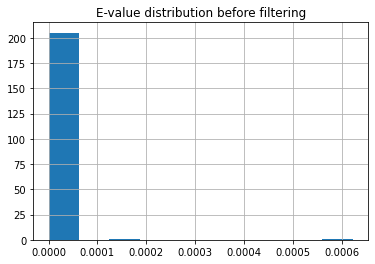

In [14]:
diamond.hist("e-value")
plt.title("E-value distribution before filtering")

Text(0.5, 1.0, 'E-value distribution after filtering')

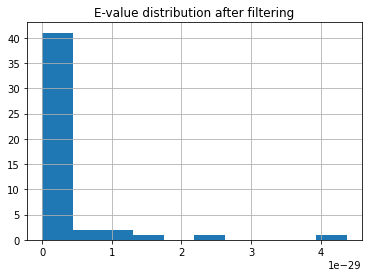

In [15]:
diamond_filtered.hist("e-value")
plt.title("E-value distribution after filtering")

Text(0.5, 1.0, 'Number of hits per contig before preprocessing')

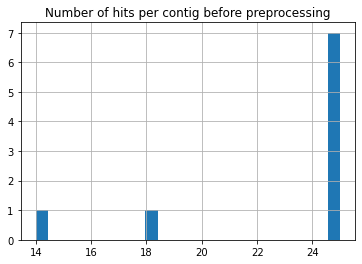

In [16]:
diamond.pivot_table(columns=['Query_id'], aggfunc='size').hist(bins = 25)
plt.title("Number of hits per contig before preprocessing")


Text(0.5, 1.0, 'Number of hits per contig after preprocessing')

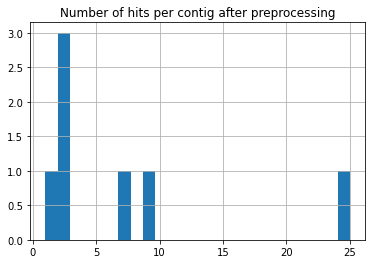

In [17]:
diamond_filtered.pivot_table(columns=['Query_id'], aggfunc='size').hist(bins = 25)
plt.title("Number of hits per contig after preprocessing")

#####  Inspect % identity and aligment length

Text(0.5, 1.0, 'Alignment length distribution before preprocessing')

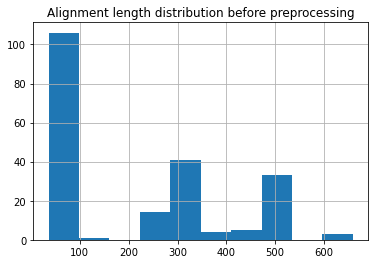

In [18]:
diamond.hist("alignment_length")
plt.title("Alignment length distribution before preprocessing")


Text(0.5, 1.0, 'Alignment length distribution after preprocessing')

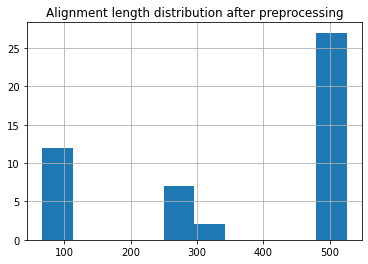

In [19]:
diamond_filtered.hist("alignment_length")
plt.title("Alignment length distribution after preprocessing")

Text(0, 0.5, 'Mistmatches')

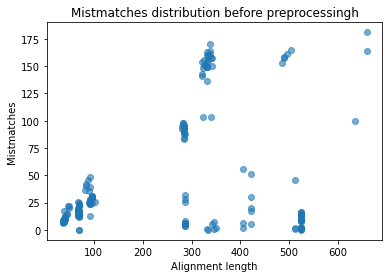

In [20]:
plt.scatter(diamond.alignment_length,diamond.mismatches,alpha=0.6)
plt.title('Mistmatches distribution before preprocessingh')
plt.xlabel('Alignment length')
plt.ylabel('Mistmatches')

Text(0, 0.5, 'Mistmatches')

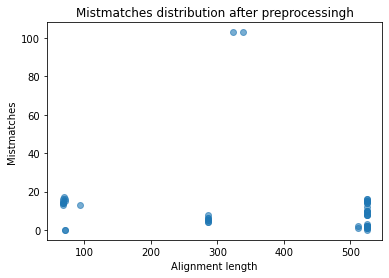

In [21]:
plt.scatter(diamond_filtered.alignment_length,diamond_filtered.mismatches,alpha=0.6)
plt.title('Mistmatches distribution after preprocessingh')
plt.xlabel('Alignment length')
plt.ylabel('Mistmatches')

Text(0.5, 1.0, 'Percentage of identity distribution before preprocessing')

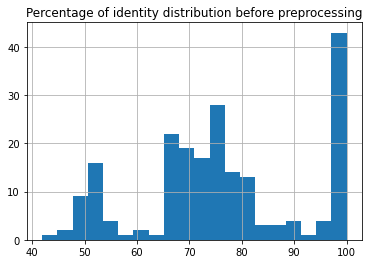

In [22]:
diamond.hist("%_identity", bins = 20)
plt.title("Percentage of identity distribution before preprocessing")


Text(0.5, 1.0, 'Percentage of identity distribution after preprocessing')

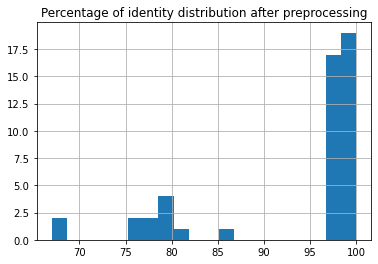

In [23]:
diamond_filtered.hist("%_identity", bins = 20)
plt.title("Percentage of identity distribution after preprocessing")

##### Link information form diamond matches and count table
First, we are going to drop all columns except for ContigsID and orthologous genes header

In [24]:
map_table = diamond_filtered.set_index('Query_id')[["Subject_id"]]
map_table

,Subject_id
Query_id,
TRINITY_DN226455_c0_g1_i1,MKWE01000003_1_73__GB_GCA_001899585_1
TRINITY_DN226457_c0_g1_i1,NZZG01000135_1_4__GB_GCA_002698575_1
TRINITY_DN226457_c0_g1_i1,NZ_FQVU01000003_1_87__RS_GCF_900129455_1
TRINITY_DN226457_c0_g1_i1,NZ_CP041091_1_1971__RS_GCF_006494815_1
TRINITY_DN226457_c0_g1_i1,NZ_SPUJ01000010_1_43__RS_GCF_004522105_1
TRINITY_DN226457_c0_g1_i1,NZ_KE383929_1_629__RS_GCF_000422825_1
TRINITY_DN226457_c0_g1_i1,SCQZ01000232_1_9__GB_GCA_004299665_1
TRINITY_DN226457_c0_g1_i1,PBYI01000065_1_5__GB_GCA_002729525_1
TRINITY_DN226457_c0_g1_i1,NZ_STGK01000002_1_307__RS_GCF_004919105_1


Now, we will merge both files by their column in common (ContigID and Subject id).

In [25]:
df = pd.merge(map_table, counts, left_index=True, right_index=True).reset_index(
  ).rename(columns={'index':'ContigID'}).set_index('Subject_id')
df


,ContigID,SampleA,SampleB,SampleC,SampleD,SampleE
Subject_id,,,,,,
MKWE01000003_1_73__GB_GCA_001899585_1,TRINITY_DN226455_c0_g1_i1,0,2,0,0,2
NZZG01000135_1_4__GB_GCA_002698575_1,TRINITY_DN226457_c0_g1_i1,3,6,0,0,0
NZ_FQVU01000003_1_87__RS_GCF_900129455_1,TRINITY_DN226457_c0_g1_i1,3,6,0,0,0
NZ_CP041091_1_1971__RS_GCF_006494815_1,TRINITY_DN226457_c0_g1_i1,3,6,0,0,0
NZ_SPUJ01000010_1_43__RS_GCF_004522105_1,TRINITY_DN226457_c0_g1_i1,3,6,0,0,0
NZ_KE383929_1_629__RS_GCF_000422825_1,TRINITY_DN226457_c0_g1_i1,3,6,0,0,0
SCQZ01000232_1_9__GB_GCA_004299665_1,TRINITY_DN226457_c0_g1_i1,3,6,0,0,0
PBYI01000065_1_5__GB_GCA_002729525_1,TRINITY_DN226457_c0_g1_i1,3,6,0,0,0
NZ_STGK01000002_1_307__RS_GCF_004919105_1,TRINITY_DN226457_c0_g1_i1,3,6,0,0,0


##### Annotating the OTU
Now, we have to annotate the previous table. 

We will use the SQLite file of AnnoTree. You can safely ignore this next chunk if you are still getting familiar with SQL. 

We are annotating only with the NCBI tax id and the KEGG and Interpro Identifier.

In [26]:
conn = sqlite3.connect(mapping_db)
VALID_COLUMNS = ('Accession', 'Taxonomy', 'GTDB', 'EGGNOG', 'INTERPRO2GO','SEED', 'EC', 'KEGG', 'PFAM', 'TIGRFAM')
MapColumn = Enum('MapColumn', [(a, a) for a in VALID_COLUMNS], type=str)

def get_column(conn: sqlite3.Connection, column: MapColumn, acc: str)-> int:
    with closing(conn.cursor()) as cursor:
        cursor.execute(f"SELECT {column.value} FROM mappings WHERE Accession = ?", (acc,))
        return cursor.fetchone()[0]

def get_NCBI_taxonomy(conn: sqlite3.Connection, acc: str)-> int:
    return get_column(conn, MapColumn.Taxonomy, acc)

def get_KEGG_KO(conn: sqlite3.Connection, acc: str)-> int:
    val = get_column(conn, MapColumn.KEGG, acc)
    if val:
        return f"K{str(val).zfill(5)}"
    return ""

def get_INTERPRO2GO(conn: sqlite3.Connection, acc: str) -> int:
    val = get_column(conn, MapColumn.INTERPRO2GO, acc)
    if val:
        return f"IPR{str(val).zfill(6)}"
    return ""    

Now we add new columns:

In [27]:
df['NCBI_TaxID'] = [get_NCBI_taxonomy(conn, acc) for acc in df.index]
df['KEGG'] = [get_KEGG_KO(conn, acc) for acc in df.index]
df['INTERPRO2GO'] = [get_INTERPRO2GO(conn, acc) for acc in df.index]
df

,ContigID,SampleA,SampleB,SampleC,SampleD,SampleE,NCBI_TaxID,KEGG,INTERPRO2GO
Subject_id,,,,,,,,,
MKWE01000003_1_73__GB_GCA_001899585_1,TRINITY_DN226455_c0_g1_i1,0,2,0,0,2,1895826,K04088,
NZZG01000135_1_4__GB_GCA_002698575_1,TRINITY_DN226457_c0_g1_i1,3,6,0,0,0,51662,K13955,
NZ_FQVU01000003_1_87__RS_GCF_900129455_1,TRINITY_DN226457_c0_g1_i1,3,6,0,0,0,1206085,K00344,
NZ_CP041091_1_1971__RS_GCF_006494815_1,TRINITY_DN226457_c0_g1_i1,3,6,0,0,0,2589074,K13955,
NZ_SPUJ01000010_1_43__RS_GCF_004522105_1,TRINITY_DN226457_c0_g1_i1,3,6,0,0,0,2508327,K00001,
NZ_KE383929_1_629__RS_GCF_000422825_1,TRINITY_DN226457_c0_g1_i1,3,6,0,0,0,1122610,K00344,
SCQZ01000232_1_9__GB_GCA_004299665_1,TRINITY_DN226457_c0_g1_i1,3,6,0,0,0,1932789,K00001,
PBYI01000065_1_5__GB_GCA_002729525_1,TRINITY_DN226457_c0_g1_i1,3,6,0,0,0,35761,K13955,
NZ_STGK01000002_1_307__RS_GCF_004919105_1,TRINITY_DN226457_c0_g1_i1,3,6,0,0,0,2569761,K00344,


# Naive lowest common ancestor

Most AnnoTree entries have a NCBI taxonomy identifier (except those with NCBI_TaxID == 0).

You can search the corresponding taxa using NCBI. For example, let's check the first five more abundant OTU:

In [28]:
# Sum all numeric columns that are not NCBI_TaxID
df['Total'] = df.loc[:, df.columns != 'NCBI_TaxID'].sum(axis=1)
for tax in df[['Total', 'NCBI_TaxID']].groupby('NCBI_TaxID').sum().sort_values('Total', ascending=False).index[:5]:
    print(f"https://www.ncbi.nlm.nih.gov/Taxonomy/Browser/wwwtax.cgi?id={tax}")
df = df.drop(columns=['Total'])


https://www.ncbi.nlm.nih.gov/Taxonomy/Browser/wwwtax.cgi?id=243261
https://www.ncbi.nlm.nih.gov/Taxonomy/Browser/wwwtax.cgi?id=553814
https://www.ncbi.nlm.nih.gov/Taxonomy/Browser/wwwtax.cgi?id=67824
https://www.ncbi.nlm.nih.gov/Taxonomy/Browser/wwwtax.cgi?id=2589074
https://www.ncbi.nlm.nih.gov/Taxonomy/Browser/wwwtax.cgi?id=2569761


Let's apply the LCA algorithm to one entry of the table:

In [29]:
from ete3 import NCBITaxa
ncbi = NCBITaxa()
example = df['ContigID'].iloc[10]
tax_ids_example = df[df['ContigID'] == example].NCBI_TaxID.tolist()
tree_example= ncbi.get_topology(tax_ids_example)
print(tree_example.get_ascii(attributes=["sci_name", "rank"]))
print(f"Assigned taxid: {tree_example.get_tree_root().name}")


                                                                             /-Escherichia sp. E1V33, species
                                                                            |
                                                                            |--Escherichia sp. B1147, species
                                                                            |
                                            /unclassified Escherichia, no rank-Escherichia sp. TW11588, species
                                           |                                |
                                           |                                |--Escherichia sp. E4742, species
                                           |                                |
                                           |                                 \-Escherichia sp. MOD1-EC7003, species
                                           |
                                           |                         /-Escherichia c

Now, we can apply it to the whole table:

In [30]:
# This is not efficient at all, but it works
def lowest_common_ancestor(tax_ids: [int])-> int:
  """Get lowest common ancestor of a list of tax ids
  First, we test for two Micromonospora. Then, two far away species (2 is Bacteria). Finally, the invariant case
  >>> lowest_common_ancestor([946078, 307120])
  '1873'
  >>> lowest_common_ancestor([1909295, 1923970])
  '2'
  >>> lowest_common_ancestor([10, 10])
  '10'
  >>> lowest_common_ancestor([10])
  '10'
  """
  # Remove zero elements
  tax_ids = [t for t in tax_ids if t != 0]
  if len(tax_ids) == 0:
    return "0"
  if len(tax_ids) == 1:
    return str(tax_ids[0])
  try:
    tree = ncbi.get_topology(tax_ids)
    root = tree.get_tree_root()
    return root.name
  except ValueError:
    # If error, try again without the last element, which is "worse" than the previous one
    return lowest_common_ancestor(tax_ids[:-1])

import doctest
doctest.testmod()

TestResults(failed=0, attempted=4)

In [31]:
df_lca = df.groupby('ContigID')['NCBI_TaxID'].apply(lowest_common_ancestor).rename('LCA').to_frame()
df_lca

,LCA
ContigID,
TRINITY_DN226455_c0_g1_i1,1895826
TRINITY_DN226457_c0_g1_i1,1760
TRINITY_DN226477_c0_g1_i1,543
TRINITY_DN2264898_c0_g1_i1,1236
TRINITY_DN226500_c0_g1_i1,1230346
TRINITY_DN78676876898_c0_g1_i1,80840


Finally, we are going to add different taxonomic ranks. First, we define a few functions. 

In [32]:
from ete3 import NCBITaxa
ncbi = NCBITaxa()

def get_lineage(taxid):
    """Get dictionary with rank as keys and name as values
    >>> get_lineage(49992).get('species')
    'Thymus vulgaris'
    >>> get_lineage(2)
    {'no rank': 'cellular organisms', 'superkingdom': 'Bacteria'}
    >>> get_lineage(0)
    {}
    """
    if taxid <= 0:
        return {}
    try:
        lineage = ncbi.get_lineage(taxid)
        ranks = ncbi.get_rank(lineage)
        names = ncbi.translate_to_names(lineage)
        return {ranks[k]: elm for k, elm  in zip(lineage, names)}
    except ValueError:
        return {}
def get_taxonomy_row(taxid):
    """
    Parse taxa into greengenes-like format
    >>> get_taxonomy_row(49992)
    'd__Eukaryota;p__Streptophyta;c__Magnoliopsida;o__Lamiales;f__Lamiaceae;g__Thymus;s__Thymus vulgaris'
    """
    lineage = get_lineage(taxid)
    ranks = {
        'superkingdom': 'd__', 'phylum':'p__', 'class': 'c__',
        'order':'o__', 'family':'f__', 'genus':'g__', 'species':'s__'
        }
    for rank in ranks:
        ranks[rank] += lineage.get(rank, '')
    return ";".join(ranks.values())

def get_taxonomy_row2(taxid):
    """
    Parse taxa separated with semicolon
    >>> get_taxonomy_row2(49992)
    'Eukaryota;Streptophyta;Magnoliopsida;Lamiales;Lamiaceae;Thymus;Thymus vulgaris'
    """
    lineage = get_lineage(taxid)
    ranks = {rank:'' for rank in (
        'superkingdom', 'phylum', 'class', 'order', 'family', 'genus', 'species'
    )}        
    for rank in ranks:
        ranks[rank] += lineage.get(rank, 'X')
    return ";".join(ranks.values())
import doctest
doctest.testmod()

TestResults(failed=0, attempted=9)

In [33]:
#[get_taxonomy_row(taxid) for taxid in taxa_df['NCBI_TaxID'][1:5]]
df_lca['Taxonomy'] = [get_taxonomy_row(int(taxid)) for taxid in df_lca['LCA']]
df_lca

,LCA,Taxonomy
ContigID,,
TRINITY_DN226455_c0_g1_i1,1895826,d__Bacteria;p__Pseudomonadota;c__Alphaproteoba...
TRINITY_DN226457_c0_g1_i1,1760,d__Bacteria;p__Actinomycetota;c__Actinomycetes...
TRINITY_DN226477_c0_g1_i1,543,d__Bacteria;p__Pseudomonadota;c__Gammaproteoba...
TRINITY_DN2264898_c0_g1_i1,1236,d__Bacteria;p__Pseudomonadota;c__Gammaproteoba...
TRINITY_DN226500_c0_g1_i1,1230346,d__Bacteria;p__Planctomycetota;c__Candidatus B...
TRINITY_DN78676876898_c0_g1_i1,80840,d__Bacteria;p__Pseudomonadota;c__Betaproteobac...


In [34]:
df = df.merge(df_lca, left_on='ContigID', right_index=True)
df

,ContigID,SampleA,SampleB,SampleC,SampleD,SampleE,NCBI_TaxID,KEGG,INTERPRO2GO,LCA,Taxonomy
Subject_id,,,,,,,,,,,
MKWE01000003_1_73__GB_GCA_001899585_1,TRINITY_DN226455_c0_g1_i1,0,2,0,0,2,1895826,K04088,,1895826,d__Bacteria;p__Pseudomonadota;c__Alphaproteoba...
NZZG01000135_1_4__GB_GCA_002698575_1,TRINITY_DN226457_c0_g1_i1,3,6,0,0,0,51662,K13955,,1760,d__Bacteria;p__Actinomycetota;c__Actinomycetes...
NZ_FQVU01000003_1_87__RS_GCF_900129455_1,TRINITY_DN226457_c0_g1_i1,3,6,0,0,0,1206085,K00344,,1760,d__Bacteria;p__Actinomycetota;c__Actinomycetes...
NZ_CP041091_1_1971__RS_GCF_006494815_1,TRINITY_DN226457_c0_g1_i1,3,6,0,0,0,2589074,K13955,,1760,d__Bacteria;p__Actinomycetota;c__Actinomycetes...
NZ_SPUJ01000010_1_43__RS_GCF_004522105_1,TRINITY_DN226457_c0_g1_i1,3,6,0,0,0,2508327,K00001,,1760,d__Bacteria;p__Actinomycetota;c__Actinomycetes...
NZ_KE383929_1_629__RS_GCF_000422825_1,TRINITY_DN226457_c0_g1_i1,3,6,0,0,0,1122610,K00344,,1760,d__Bacteria;p__Actinomycetota;c__Actinomycetes...
SCQZ01000232_1_9__GB_GCA_004299665_1,TRINITY_DN226457_c0_g1_i1,3,6,0,0,0,1932789,K00001,,1760,d__Bacteria;p__Actinomycetota;c__Actinomycetes...
PBYI01000065_1_5__GB_GCA_002729525_1,TRINITY_DN226457_c0_g1_i1,3,6,0,0,0,35761,K13955,,1760,d__Bacteria;p__Actinomycetota;c__Actinomycetes...
NZ_STGK01000002_1_307__RS_GCF_004919105_1,TRINITY_DN226457_c0_g1_i1,3,6,0,0,0,2569761,K00344,,1760,d__Bacteria;p__Actinomycetota;c__Actinomycetes...


### Functional annotation

Now, we are going to annotate the OTU with the KEGG and Interpro identifiers. Let's check how many non-annotated entries do we have:

In [35]:
print(f"There are {df.shape[0]} rows in the dataframe")
print(f"There are {(df['KEGG'] == '').sum()} rows with no KEGG identifier")
print(f"There are {(df['INTERPRO2GO'] == '').sum()} rows with no INTERPRO2GO identifier")


There are 46 rows in the dataframe
There are 0 rows with no KEGG identifier
There are 21 rows with no INTERPRO2GO identifier


##### Adding BRITE high-level annotations
Now, we can use KEGG BRITE to add high-level annotations to this table. It's not pretty code, but it works:



In [36]:
import json
with open(brite_json, 'r') as json_file:
    # Read the contents of the file
    json_data = json_file.read()
    # Parse the JSON data
    brite = json.loads(json_data)
def get_brite(kos, include = [], ):
    annotations = dict()
    for LevelA in brite['children']:
            if LevelA['name'] not in include:
                continue
            for LevelB in LevelA.get('children', []):
                for LevelC in LevelB.get('children', []):
                    for LevelD in LevelC.get('children', []):
                        name = LevelD['name'].split()[0]
                        if name in kos:
                            description = LevelD['name'].split(';')[1].strip()
                            new_annotation = (LevelA['name'], LevelB['name'], LevelC['name'], description)
                            if name in annotations:
                                annotations[name].append(new_annotation)
                            annotations[name] = [new_annotation]
    return annotations

Now, we get some annotations. We have to decide which annotations to use. Those are the ones available in the BRITE hierarchy:

In [37]:
[y['name'] for y in brite['children']]

['09100 Metabolism',
 '09120 Genetic Information Processing',
 '09130 Environmental Information Processing',
 '09140 Cellular Processes',
 '09150 Organismal Systems',
 '09160 Human Diseases',
 '09180 Brite Hierarchies',
 '09190 Not Included in Pathway or Brite']

We are going to use annotate with both Brite and Metabolism.

### Adding Brite hierarchy

In [38]:
annotations = get_brite(df.KEGG.to_list(), include = '09180 Brite Hierarchies') 

And we add them to the DataFrame

In [39]:
df['Brite_Level1'] = [",".join(x[1] for x in annotations[ko]) if ko in annotations else '' for ko in df.KEGG.to_list()]
df['Brite_Level2'] = [",".join(x[2] for x in annotations[ko]) if ko in annotations else '' for ko in df.KEGG.to_list()]
df['Brite_Level3'] = [",".join(x[3] for x in annotations[ko]) if ko in annotations else '' for ko in df.KEGG.to_list()]
df

,ContigID,SampleA,SampleB,SampleC,SampleD,SampleE,NCBI_TaxID,KEGG,INTERPRO2GO,LCA,Taxonomy,Brite_Level1,Brite_Level2,Brite_Level3
Subject_id,,,,,,,,,,,,,,
MKWE01000003_1_73__GB_GCA_001899585_1,TRINITY_DN226455_c0_g1_i1,0,2,0,0,2,1895826,K04088,,1895826,d__Bacteria;p__Pseudomonadota;c__Alphaproteoba...,09181 Protein families: metabolism,01002 Peptidases and inhibitors [BR:ko01002],modulator of FtsH protease HflK
NZZG01000135_1_4__GB_GCA_002698575_1,TRINITY_DN226457_c0_g1_i1,3,6,0,0,0,51662,K13955,,1760,d__Bacteria;p__Actinomycetota;c__Actinomycetes...,,,
NZ_FQVU01000003_1_87__RS_GCF_900129455_1,TRINITY_DN226457_c0_g1_i1,3,6,0,0,0,1206085,K00344,,1760,d__Bacteria;p__Actinomycetota;c__Actinomycetes...,,,
NZ_CP041091_1_1971__RS_GCF_006494815_1,TRINITY_DN226457_c0_g1_i1,3,6,0,0,0,2589074,K13955,,1760,d__Bacteria;p__Actinomycetota;c__Actinomycetes...,,,
NZ_SPUJ01000010_1_43__RS_GCF_004522105_1,TRINITY_DN226457_c0_g1_i1,3,6,0,0,0,2508327,K00001,,1760,d__Bacteria;p__Actinomycetota;c__Actinomycetes...,,,
NZ_KE383929_1_629__RS_GCF_000422825_1,TRINITY_DN226457_c0_g1_i1,3,6,0,0,0,1122610,K00344,,1760,d__Bacteria;p__Actinomycetota;c__Actinomycetes...,,,
SCQZ01000232_1_9__GB_GCA_004299665_1,TRINITY_DN226457_c0_g1_i1,3,6,0,0,0,1932789,K00001,,1760,d__Bacteria;p__Actinomycetota;c__Actinomycetes...,,,
PBYI01000065_1_5__GB_GCA_002729525_1,TRINITY_DN226457_c0_g1_i1,3,6,0,0,0,35761,K13955,,1760,d__Bacteria;p__Actinomycetota;c__Actinomycetes...,,,
NZ_STGK01000002_1_307__RS_GCF_004919105_1,TRINITY_DN226457_c0_g1_i1,3,6,0,0,0,2569761,K00344,,1760,d__Bacteria;p__Actinomycetota;c__Actinomycetes...,,,


Let's show a few annotated rows: 

In [40]:
df[df['Brite_Level1'] != '']

,ContigID,SampleA,SampleB,SampleC,SampleD,SampleE,NCBI_TaxID,KEGG,INTERPRO2GO,LCA,Taxonomy,Brite_Level1,Brite_Level2,Brite_Level3
Subject_id,,,,,,,,,,,,,,
MKWE01000003_1_73__GB_GCA_001899585_1,TRINITY_DN226455_c0_g1_i1,0,2,0,0,2,1895826,K04088,,1895826,d__Bacteria;p__Pseudomonadota;c__Alphaproteoba...,09181 Protein families: metabolism,01002 Peptidases and inhibitors [BR:ko01002],modulator of FtsH protease HflK
NZ_CP027579_1_4510__RS_GCF_003018335_1,TRINITY_DN226477_c0_g1_i1,0,0,0,0,0,562,K01951,IPR022955,543,d__Bacteria;p__Pseudomonadota;c__Gammaproteoba...,09181 Protein families: metabolism,01002 Peptidases and inhibitors [BR:ko01002],GMP synthase (glutamine-hydrolysing) [EC:6.3.5.2]
NC_011740_1_613__RS_GCF_000026225_1,TRINITY_DN226477_c0_g1_i1,0,0,0,0,0,585054,K01951,IPR022955,543,d__Bacteria;p__Pseudomonadota;c__Gammaproteoba...,09181 Protein families: metabolism,01002 Peptidases and inhibitors [BR:ko01002],GMP synthase (glutamine-hydrolysing) [EC:6.3.5.2]
NZ_CP033092_2_1316__RS_GCF_003697165_2,TRINITY_DN226477_c0_g1_i1,0,0,0,0,0,866789,K01951,IPR022955,543,d__Bacteria;p__Pseudomonadota;c__Gammaproteoba...,09181 Protein families: metabolism,01002 Peptidases and inhibitors [BR:ko01002],GMP synthase (glutamine-hydrolysing) [EC:6.3.5.2]
NZ_CP026788_1_4465__RS_GCF_002950215_1,TRINITY_DN226477_c0_g1_i1,0,0,0,0,0,42897,K01951,IPR022955,543,d__Bacteria;p__Pseudomonadota;c__Gammaproteoba...,09181 Protein families: metabolism,01002 Peptidases and inhibitors [BR:ko01002],GMP synthase (glutamine-hydrolysing) [EC:6.3.5.2]
NZ_CP026774_1_4322__RS_GCF_002949675_1,TRINITY_DN226477_c0_g1_i1,0,0,0,0,0,622,K01951,IPR022955,543,d__Bacteria;p__Pseudomonadota;c__Gammaproteoba...,09181 Protein families: metabolism,01002 Peptidases and inhibitors [BR:ko01002],GMP synthase (glutamine-hydrolysing) [EC:6.3.5.2]
NZ_PTRE01000188_1_20__RS_GCF_002965065_1,TRINITY_DN226477_c0_g1_i1,0,0,0,0,0,2093900,K01951,,543,d__Bacteria;p__Pseudomonadota;c__Gammaproteoba...,09181 Protein families: metabolism,01002 Peptidases and inhibitors [BR:ko01002],GMP synthase (glutamine-hydrolysing) [EC:6.3.5.2]
NC_011751_1_2733__RS_GCF_000026325_1,TRINITY_DN226477_c0_g1_i1,0,0,0,0,0,585056,K01951,IPR022955,543,d__Bacteria;p__Pseudomonadota;c__Gammaproteoba...,09181 Protein families: metabolism,01002 Peptidases and inhibitors [BR:ko01002],GMP synthase (glutamine-hydrolysing) [EC:6.3.5.2]
NZ_CP040443_1_478__RS_GCF_005843885_1,TRINITY_DN226477_c0_g1_i1,0,0,0,0,0,2044467,K01951,IPR032818,543,d__Bacteria;p__Pseudomonadota;c__Gammaproteoba...,09181 Protein families: metabolism,01002 Peptidases and inhibitors [BR:ko01002],GMP synthase (glutamine-hydrolysing) [EC:6.3.5.2]


In [41]:
df.index.name = 'ContigID'
df

,ContigID,SampleA,SampleB,SampleC,SampleD,SampleE,NCBI_TaxID,KEGG,INTERPRO2GO,LCA,Taxonomy,Brite_Level1,Brite_Level2,Brite_Level3
ContigID,,,,,,,,,,,,,,
MKWE01000003_1_73__GB_GCA_001899585_1,TRINITY_DN226455_c0_g1_i1,0,2,0,0,2,1895826,K04088,,1895826,d__Bacteria;p__Pseudomonadota;c__Alphaproteoba...,09181 Protein families: metabolism,01002 Peptidases and inhibitors [BR:ko01002],modulator of FtsH protease HflK
NZZG01000135_1_4__GB_GCA_002698575_1,TRINITY_DN226457_c0_g1_i1,3,6,0,0,0,51662,K13955,,1760,d__Bacteria;p__Actinomycetota;c__Actinomycetes...,,,
NZ_FQVU01000003_1_87__RS_GCF_900129455_1,TRINITY_DN226457_c0_g1_i1,3,6,0,0,0,1206085,K00344,,1760,d__Bacteria;p__Actinomycetota;c__Actinomycetes...,,,
NZ_CP041091_1_1971__RS_GCF_006494815_1,TRINITY_DN226457_c0_g1_i1,3,6,0,0,0,2589074,K13955,,1760,d__Bacteria;p__Actinomycetota;c__Actinomycetes...,,,
NZ_SPUJ01000010_1_43__RS_GCF_004522105_1,TRINITY_DN226457_c0_g1_i1,3,6,0,0,0,2508327,K00001,,1760,d__Bacteria;p__Actinomycetota;c__Actinomycetes...,,,
NZ_KE383929_1_629__RS_GCF_000422825_1,TRINITY_DN226457_c0_g1_i1,3,6,0,0,0,1122610,K00344,,1760,d__Bacteria;p__Actinomycetota;c__Actinomycetes...,,,
SCQZ01000232_1_9__GB_GCA_004299665_1,TRINITY_DN226457_c0_g1_i1,3,6,0,0,0,1932789,K00001,,1760,d__Bacteria;p__Actinomycetota;c__Actinomycetes...,,,
PBYI01000065_1_5__GB_GCA_002729525_1,TRINITY_DN226457_c0_g1_i1,3,6,0,0,0,35761,K13955,,1760,d__Bacteria;p__Actinomycetota;c__Actinomycetes...,,,
NZ_STGK01000002_1_307__RS_GCF_004919105_1,TRINITY_DN226457_c0_g1_i1,3,6,0,0,0,2569761,K00344,,1760,d__Bacteria;p__Actinomycetota;c__Actinomycetes...,,,


### Adding KEGG metabolism

In [42]:
annotations = get_brite(df.KEGG.to_list(), include = '09100 Metabolism') 

In [43]:
df['Metabolism_Level1'] = [",".join(x[1] for x in annotations[ko]) if ko in annotations else '' for ko in df.KEGG.to_list()]
df['Metabolism_Level2'] = [",".join(x[2] for x in annotations[ko]) if ko in annotations else '' for ko in df.KEGG.to_list()]
df['Metabolism_Level3'] = [",".join(x[3] for x in annotations[ko]) if ko in annotations else '' for ko in df.KEGG.to_list()]
df

,ContigID,SampleA,SampleB,SampleC,SampleD,SampleE,NCBI_TaxID,KEGG,INTERPRO2GO,LCA,Taxonomy,Brite_Level1,Brite_Level2,Brite_Level3,Metabolism_Level1,Metabolism_Level2,Metabolism_Level3
ContigID,,,,,,,,,,,,,,,,,
MKWE01000003_1_73__GB_GCA_001899585_1,TRINITY_DN226455_c0_g1_i1,0,2,0,0,2,1895826,K04088,,1895826,d__Bacteria;p__Pseudomonadota;c__Alphaproteoba...,09181 Protein families: metabolism,01002 Peptidases and inhibitors [BR:ko01002],modulator of FtsH protease HflK,,,
NZZG01000135_1_4__GB_GCA_002698575_1,TRINITY_DN226457_c0_g1_i1,3,6,0,0,0,51662,K13955,,1760,d__Bacteria;p__Actinomycetota;c__Actinomycetes...,,,,,,
NZ_FQVU01000003_1_87__RS_GCF_900129455_1,TRINITY_DN226457_c0_g1_i1,3,6,0,0,0,1206085,K00344,,1760,d__Bacteria;p__Actinomycetota;c__Actinomycetes...,,,,,,
NZ_CP041091_1_1971__RS_GCF_006494815_1,TRINITY_DN226457_c0_g1_i1,3,6,0,0,0,2589074,K13955,,1760,d__Bacteria;p__Actinomycetota;c__Actinomycetes...,,,,,,
NZ_SPUJ01000010_1_43__RS_GCF_004522105_1,TRINITY_DN226457_c0_g1_i1,3,6,0,0,0,2508327,K00001,,1760,d__Bacteria;p__Actinomycetota;c__Actinomycetes...,,,,09111 Xenobiotics biodegradation and metabolism,00982 Drug metabolism - cytochrome P450 [PATH:...,alcohol dehydrogenase [EC:1.1.1.1]
NZ_KE383929_1_629__RS_GCF_000422825_1,TRINITY_DN226457_c0_g1_i1,3,6,0,0,0,1122610,K00344,,1760,d__Bacteria;p__Actinomycetota;c__Actinomycetes...,,,,,,
SCQZ01000232_1_9__GB_GCA_004299665_1,TRINITY_DN226457_c0_g1_i1,3,6,0,0,0,1932789,K00001,,1760,d__Bacteria;p__Actinomycetota;c__Actinomycetes...,,,,09111 Xenobiotics biodegradation and metabolism,00982 Drug metabolism - cytochrome P450 [PATH:...,alcohol dehydrogenase [EC:1.1.1.1]
PBYI01000065_1_5__GB_GCA_002729525_1,TRINITY_DN226457_c0_g1_i1,3,6,0,0,0,35761,K13955,,1760,d__Bacteria;p__Actinomycetota;c__Actinomycetes...,,,,,,
NZ_STGK01000002_1_307__RS_GCF_004919105_1,TRINITY_DN226457_c0_g1_i1,3,6,0,0,0,2569761,K00344,,1760,d__Bacteria;p__Actinomycetota;c__Actinomycetes...,,,,,,


Let's show a few annotated rows: 

In [44]:
df[df['Metabolism_Level1'] != '']

,ContigID,SampleA,SampleB,SampleC,SampleD,SampleE,NCBI_TaxID,KEGG,INTERPRO2GO,LCA,Taxonomy,Brite_Level1,Brite_Level2,Brite_Level3,Metabolism_Level1,Metabolism_Level2,Metabolism_Level3
ContigID,,,,,,,,,,,,,,,,,
NZ_SPUJ01000010_1_43__RS_GCF_004522105_1,TRINITY_DN226457_c0_g1_i1,3,6,0,0,0,2508327,K00001,,1760,d__Bacteria;p__Actinomycetota;c__Actinomycetes...,,,,09111 Xenobiotics biodegradation and metabolism,00982 Drug metabolism - cytochrome P450 [PATH:...,alcohol dehydrogenase [EC:1.1.1.1]
SCQZ01000232_1_9__GB_GCA_004299665_1,TRINITY_DN226457_c0_g1_i1,3,6,0,0,0,1932789,K00001,,1760,d__Bacteria;p__Actinomycetota;c__Actinomycetes...,,,,09111 Xenobiotics biodegradation and metabolism,00982 Drug metabolism - cytochrome P450 [PATH:...,alcohol dehydrogenase [EC:1.1.1.1]
NZ_VDMR01000003_1_65__RS_GCF_006346315_1,TRINITY_DN226457_c0_g1_i1,3,6,0,0,0,1926648,K00001,,1760,d__Bacteria;p__Actinomycetota;c__Actinomycetes...,,,,09111 Xenobiotics biodegradation and metabolism,00982 Drug metabolism - cytochrome P450 [PATH:...,alcohol dehydrogenase [EC:1.1.1.1]
NZ_CP027579_1_4510__RS_GCF_003018335_1,TRINITY_DN226477_c0_g1_i1,0,0,0,0,0,562,K01951,IPR022955,543,d__Bacteria;p__Pseudomonadota;c__Gammaproteoba...,09181 Protein families: metabolism,01002 Peptidases and inhibitors [BR:ko01002],GMP synthase (glutamine-hydrolysing) [EC:6.3.5.2],09111 Xenobiotics biodegradation and metabolism,00983 Drug metabolism - other enzymes [PATH:ko...,GMP synthase (glutamine-hydrolysing) [EC:6.3.5.2]
NC_011740_1_613__RS_GCF_000026225_1,TRINITY_DN226477_c0_g1_i1,0,0,0,0,0,585054,K01951,IPR022955,543,d__Bacteria;p__Pseudomonadota;c__Gammaproteoba...,09181 Protein families: metabolism,01002 Peptidases and inhibitors [BR:ko01002],GMP synthase (glutamine-hydrolysing) [EC:6.3.5.2],09111 Xenobiotics biodegradation and metabolism,00983 Drug metabolism - other enzymes [PATH:ko...,GMP synthase (glutamine-hydrolysing) [EC:6.3.5.2]
NZ_CP033092_2_1316__RS_GCF_003697165_2,TRINITY_DN226477_c0_g1_i1,0,0,0,0,0,866789,K01951,IPR022955,543,d__Bacteria;p__Pseudomonadota;c__Gammaproteoba...,09181 Protein families: metabolism,01002 Peptidases and inhibitors [BR:ko01002],GMP synthase (glutamine-hydrolysing) [EC:6.3.5.2],09111 Xenobiotics biodegradation and metabolism,00983 Drug metabolism - other enzymes [PATH:ko...,GMP synthase (glutamine-hydrolysing) [EC:6.3.5.2]
NZ_CP026788_1_4465__RS_GCF_002950215_1,TRINITY_DN226477_c0_g1_i1,0,0,0,0,0,42897,K01951,IPR022955,543,d__Bacteria;p__Pseudomonadota;c__Gammaproteoba...,09181 Protein families: metabolism,01002 Peptidases and inhibitors [BR:ko01002],GMP synthase (glutamine-hydrolysing) [EC:6.3.5.2],09111 Xenobiotics biodegradation and metabolism,00983 Drug metabolism - other enzymes [PATH:ko...,GMP synthase (glutamine-hydrolysing) [EC:6.3.5.2]
NZ_CP026774_1_4322__RS_GCF_002949675_1,TRINITY_DN226477_c0_g1_i1,0,0,0,0,0,622,K01951,IPR022955,543,d__Bacteria;p__Pseudomonadota;c__Gammaproteoba...,09181 Protein families: metabolism,01002 Peptidases and inhibitors [BR:ko01002],GMP synthase (glutamine-hydrolysing) [EC:6.3.5.2],09111 Xenobiotics biodegradation and metabolism,00983 Drug metabolism - other enzymes [PATH:ko...,GMP synthase (glutamine-hydrolysing) [EC:6.3.5.2]
NZ_PTRE01000188_1_20__RS_GCF_002965065_1,TRINITY_DN226477_c0_g1_i1,0,0,0,0,0,2093900,K01951,,543,d__Bacteria;p__Pseudomonadota;c__Gammaproteoba...,09181 Protein families: metabolism,01002 Peptidases and inhibitors [BR:ko01002],GMP synthase (glutamine-hydrolysing) [EC:6.3.5.2],09111 Xenobiotics biodegradation and metabolism,00983 Drug metabolism - other enzymes [PATH:ko...,GMP synthase (glutamine-hydrolysing) [EC:6.3.5.2]


In [45]:
df.to_csv('../results/AnnoTree_matches_annotated.tsv', sep='\t')